### Энкодер для спутниковых снимков

Модель для перевода спутниковых снимков в признаковое пространство предобученного генератора

In [166]:
import torch
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable as V
from torch.nn import functional as F
import torchvision.utils as vutils
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim


from PIL import Image,  UnidentifiedImageError
import matplotlib.pyplot as plt
import numpy as np
import os

Файлы для спутниковых снимков и снимков местности лежат в соответствующих папках. Названия файлов совпадают, и являются координатами геопривязки исходной фотографии.

In [167]:
landscapes_path = './images_/landscapes/';
satellites_path = './satellites/';
file_list = os.listdir(satellites_path)

#### Датасет для пейзажных снимков местности

В нашем случае преобразуем их к размеру 128х128. Генератор предобучен генерировать изображения этого размера.

In [174]:
landscapes_transforms = transforms.Compose([
   transforms.Resize(128),
   transforms.CenterCrop(128),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]);

class LandscapesDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames

    def __getitem__(self, i):
        filename = self.filenames[i]
        
        image = Image.open(landscapes_path + filename, mode='r')
        image = image.convert('RGB')
        
        return landscapes_transforms(image)

    def __len__(self):
        return len(self.filenames)


#### Датасет для спутниковых снимков

Исходные снимки размера 450х450. Преобразуем их сначала к размеру 360х360, а затем вырезаем центр размером 128х128.

In [169]:
satellites_transforms = transforms.Compose([
   transforms.Resize(360),
   transforms.CenterCrop(128),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]);

class SatellitesDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames

    def __getitem__(self, i):
        filename = self.filenames[i]
        
        image = Image.open(satellites_path + filename, mode='r')
        image = image.convert('RGB')
        
        return satellites_transforms(image)

    def __len__(self):
        return len(self.filenames)


In [170]:
batch_size = 64

landscapes_dataset = LandscapesDataset(file_list)
landscapes_dataloader = torch.utils.data.DataLoader(landscapes_dataset, batch_size=batch_size)

satellites_dataset = SatellitesDataset(file_list)
satellites_dataloader = torch.utils.data.DataLoader(satellites_dataset, batch_size=batch_size)

#### Предобученный генератор

Объявляем модель и инициализиуем ее сохраненными ранее весами

In [161]:
nc = 3
nz = 4
ngf = 64
ndf = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 64 x 64``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 128 x 128``
        )

    def forward(self, input):
        return self.main(input)

In [172]:
netG = Generator()
netG.load_state_dict(torch.load('netG_4_128_800_weights.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

#### Примеры изображений

Посмотрим на результат работы генератора, пейзажные и спутниковые снимки

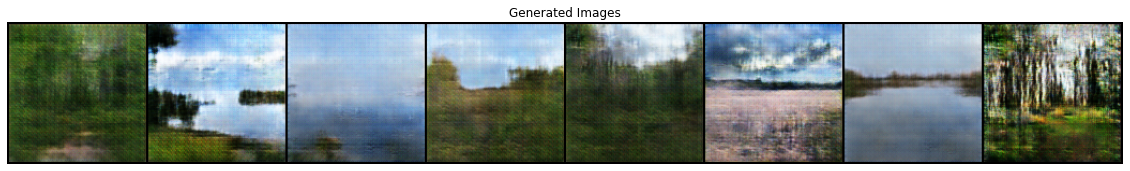

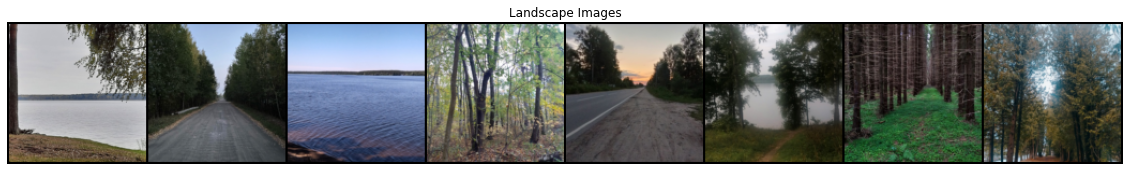

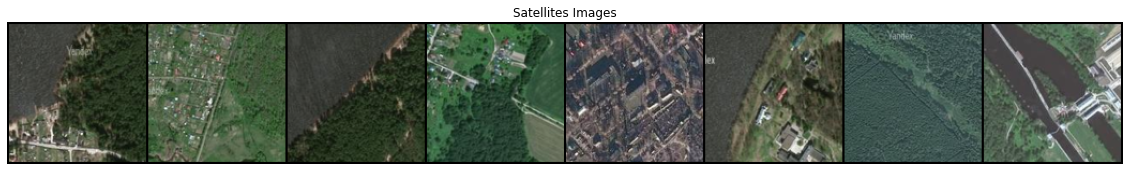

In [175]:
noise = torch.randn(8, nz, 1, 1)

generated = netG(noise).detach().cpu()
plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated, padding=2, normalize=True).cpu(),(1,2,0)))

landscapes_batch = next(iter(landscapes_dataloader))
plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Landscape Images")
plt.imshow(np.transpose(vutils.make_grid(landscapes_batch[:8], padding=2, normalize=True).cpu(),(1,2,0)))

satellites_batch = next(iter(satellites_dataloader))
plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Satellites Images")
plt.imshow(np.transpose(vutils.make_grid(satellites_batch[:8], padding=2, normalize=True).cpu(),(1,2,0)))

Сейчас изображения генератора продуцируются белым шумом и не совпадают с фотографиями местности.
Задача - научиться получать приближенно похожий результат.

#### Классификтор пейзажных фотографий

Будем использовать его в loss-функции для получения результатов, схожих исходным фотографиям местности

In [176]:
arch = 'resnet18'

model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)
    
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
print('Loaded pretrained model for place recognition')

file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

Loaded pretrained model for place recognition


0.519 -> marsh
0.139 -> canal/natural
0.099 -> swamp
0.090 -> lake/natural
0.056 -> river


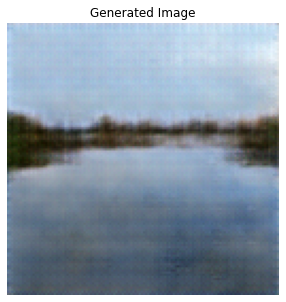

In [190]:
import torchvision.transforms.functional as TF

centre_crop = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
])

input_img = generated[6]

plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Generated Image")
plt.imshow(np.transpose(vutils.make_grid(input_img, padding=2, normalize=True).cpu(),(1,2,0)))

logit = model.forward(generated[6:7])
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.760 -> forest/broadleaf
0.155 -> forest_path
0.024 -> vineyard
0.016 -> tree_farm
0.010 -> rainforest


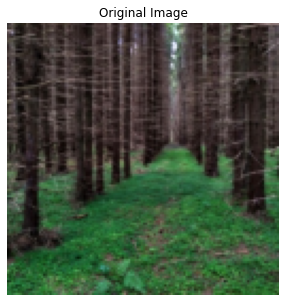

In [192]:
input_img = landscapes_batch[6]

plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(input_img, padding=2, normalize=True).cpu(),(1,2,0)))

logit = model.forward(landscapes_batch[6:7])
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

In [203]:
mseloss = nn.MSELoss()

resize_transform = transforms.Resize(224, antialias=True)

def class_norm_criterion(tensor1, tensor2, mean, variance):
    logit1 = model.forward(resize_transform(tensor1))
    logit2 = model.forward(resize_transform(tensor2))

    MSE_CLASS = mseloss(logit1, logit2)
    MSE_NORM = mean.pow(2) + (1 - variance).pow(2)

    return MSE_CLASS + MSE_NORM
         
print(class_norm_criterion(generated[:8], landscapes_batch[:8], torch.tensor(0), torch.tensor(1)))

tensor(4.1748, grad_fn=<AddBackward0>)


#### Модель энкодера

Каскад сверток от трехканального изображения размером 128x128 пикселей в 4-мерное скрытое пространство признаков.

In [199]:
ndf = 16

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 128 x 128``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size ``(ndf) x 64 x 64``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf * 2) x 32 x 32``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 16 x 16``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 8 x 8``
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*16) x 4 x 4``
            nn.Flatten(),
            nn.Linear(ndf*16*4*4, nz)
        )

    def forward(self, input):
        return self.main(input)
    

In [205]:
netE = Encoder()

#### Обучение энкодера

Обучаем энкодер спутниковыми снимками. Из полученного тензора генерируем изображения с помощью генератора и сравниваем их с исходными пейзажными фотографиями. Смотрим на два момента: 

1. Соответствие классов на полученном и оригинальном изображениях
2. Близость итогового распределения точек в пространстве признаков к нормальному

In [206]:
# Training Loop
from math import floor

losses = []

criterion = class_norm_criterion
optimizerE = optim.Adam(netE.parameters(), lr=0.00001)

num_epochs = 10

print("Starting Training Loop...")
for epoch in range(num_epochs):
    landscapes_iterator = iter(landscapes_dataloader)
    satellites_iterator = iter(satellites_dataloader)

    for i in range(floor(len(file_list)/batch_size)):
        landscapes_batch = next(landscapes_iterator)
        satellites_batch = next(satellites_iterator)
        
        netE.zero_grad()
        
        prediction = netE(satellites_batch).unsqueeze(-1).unsqueeze(-1)
        generated_batch = netG(prediction)
        
        mean = torch.mean(prediction)
        variance = torch.var(prediction)
        
        errE = criterion(generated_batch, landscapes_batch, mean, variance)
        errE.backward()
        
        optimizerE.step()
        
        losses.append(errE.item())
        
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_E: %.4f'
                  % (epoch, num_epochs, i, len(satellites_dataloader), errE.item()))
        

Starting Training Loop...
[0/10][0/25]	Loss_E: 4.5237
[0/10][10/25]	Loss_E: 4.3122
[0/10][20/25]	Loss_E: 4.2636
[1/10][0/25]	Loss_E: 4.1391
[1/10][10/25]	Loss_E: 3.9378
[1/10][20/25]	Loss_E: 3.9477
[2/10][0/25]	Loss_E: 3.6690
[2/10][10/25]	Loss_E: 3.6823
[2/10][20/25]	Loss_E: 3.6639
[3/10][0/25]	Loss_E: 3.3937
[3/10][10/25]	Loss_E: 3.4536
[3/10][20/25]	Loss_E: 3.4444
[4/10][0/25]	Loss_E: 3.1705
[4/10][10/25]	Loss_E: 3.2282
[4/10][20/25]	Loss_E: 3.2842
[5/10][0/25]	Loss_E: 3.0908
[5/10][10/25]	Loss_E: 3.1269
[5/10][20/25]	Loss_E: 3.2104
[6/10][0/25]	Loss_E: 3.0582
[6/10][10/25]	Loss_E: 3.0793
[6/10][20/25]	Loss_E: 3.1143
[7/10][0/25]	Loss_E: 3.0232
[7/10][10/25]	Loss_E: 3.0419
[7/10][20/25]	Loss_E: 3.0537
[8/10][0/25]	Loss_E: 3.0039
[8/10][10/25]	Loss_E: 3.0043
[8/10][20/25]	Loss_E: 3.0213
[9/10][0/25]	Loss_E: 2.9874
[9/10][10/25]	Loss_E: 2.9812
[9/10][20/25]	Loss_E: 2.9834


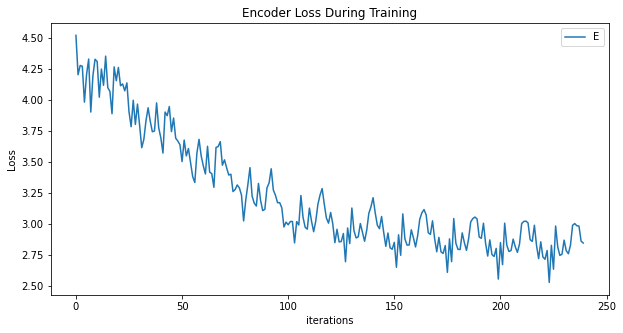

In [207]:
plt.figure(figsize=(10,5))
plt.title("Encoder Loss During Training")
plt.plot(losses,label="E")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
torch.save(netE.state_dict(), 'netE_weights.pth')

Взглянем на результаты

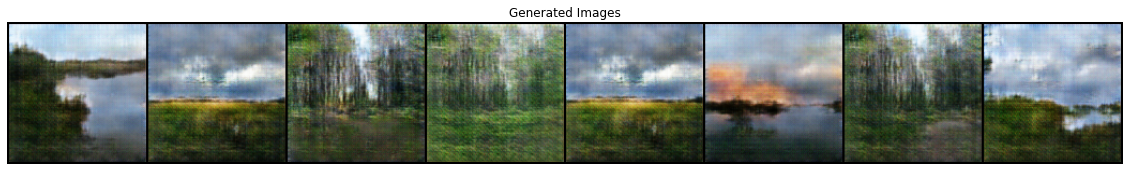

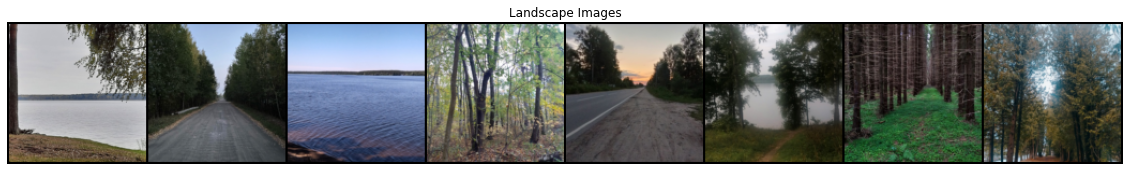

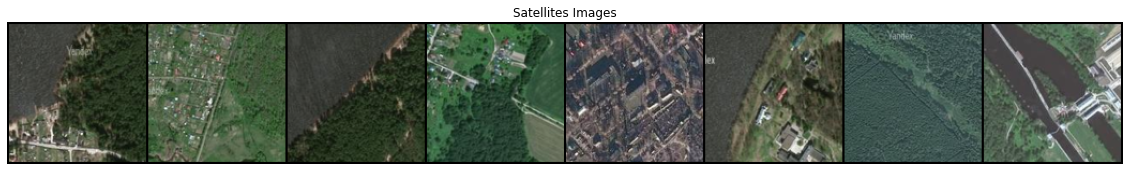

In [208]:
landscapes_iterator = iter(landscapes_dataloader)
satellites_iterator = iter(satellites_dataloader)

landscapes_batch = next(landscapes_iterator)
satellites_batch = next(satellites_iterator)

prediction = netE(satellites_batch).unsqueeze(-1).unsqueeze(-1)
generated_batch = netG(prediction)

plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_batch[:8], padding=2, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Landscape Images")
plt.imshow(np.transpose(vutils.make_grid(landscapes_batch[:8], padding=2, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Satellites Images")
plt.imshow(np.transpose(vutils.make_grid(satellites_batch[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [209]:
mean = torch.mean(prediction)
variance = torch.var(prediction)

mean, variance

(tensor(0.0122, grad_fn=<MeanBackward0>),
 tensor(1.0611, grad_fn=<VarBackward0>))